In [241]:

import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Read tree as pandas dataframe using uproot
tfile = uproot.open('../datafiles/output/davinci_MC_PID.root')
tree = tfile["PiTree/DecayTree"]
df = tree.pandas.df()
#print(df.head())

# make new PID label abs
df['absid'] = df['pi_TRUEID'].abs()
print(df['absid'].value_counts())

# make cuts on dataset
crit_global = (df['pi_TRACK_time_err'] > 0.1) & (df['pi_P'] > 1200)
crit_types  = (abs(df['pi_TRUEID']) == 211) | (abs(df['pi_TRUEID']) == 321) # only kaon or pion
dfsel = df[crit_global & crit_types]
#pion = 211, kaon = 321, proton = 2212


# define 'attributes' to train on:
attributesTRACK = ['TrackP','TrackPt','TrackChi2PerDof','TrackNumDof','TrackLikelihood']
attributesRICH = ['RichUsedAero', 'RichUsedR1Gas', 'RichUsedR2Gas', 'RichAboveMuThres', 'RichAboveKaThres']
attributesDLLS = ['RichDLLe','RichDLLmu','RichDLLk','RichDLLp','RichDLLbt']
attributesMuon = ['MuonBkgLL', 'MuonMuLL', 'MuonIsMuon', 'MuonNShared', 'InAccMuon', 'MuonIsLooseMuon']
attributesCALO = ['EcalPIDe', 'EcalPIDmu', 'HcalPIDe', 'HcalPIDmu', 'PrsPIDe', 'InAccBrem', 'BremPIDe']
attributesOther = ['VeloCharge', 'pi_TRACK_time','pi_TRACK_time_err']
probability = ['pi_MC12TuneV4_ProbNNk']
attributes = attributesTRACK + attributesRICH + attributesDLLS + attributesCALO + attributesOther
X = dfsel.loc[ :, attributes ]
#print(X.head()) #this is the data of momentumx,y,z etc.

# define 'labels'
y = dfsel['absid'].astype('category') #this relates to the table earlier that shows the attributes per 321 or 211
print(y.head()) #this just says whether it is 321 or 211


#split sample into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20) # this splits the data by row i.e. only 321 or 211 with all its attributes but we don't know if it's 321 or 211


# feature scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


#train classifier on train data
print("Training...")
from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(len(attributes), int(len(attributes)/2), 10), max_iter=200, activation='relu', solver='adam', verbose=1)  
mlp.fit(X_train, y_train.values.ravel()) 


# make label predictions on test data
predictions = mlp.predict(X_test) #this gives a 321 OR 211 label on the data 

# evaluation
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion matrix:")
print(confusion_matrix(y_test,predictions))
print("Classification report:")
print(classification_report(y_test,predictions))

#X_test comes with y_test
# create a classification variable based on the prediction probability
probabilities = mlp.predict_proba(X_test) # gives list of [prob_pion, prob_kaon]
class_var = np.array( [ probabilities[i][0] for i in range(len(y_test)) ] ) # creates a list of prob_pion. only takes the first column of probabilities
df_test = pd.DataFrame(data=X_test, columns=attributes)
df_test["myMLP"] = class_var
df_test["absid"] = y_test

#changing labels from 321 and 211 to 0 and 1
y_labels = np.array([y_test[:][i] for i in range(len(y_test)) ] ) #this is the original testing data 
y_labels_b = (y_labels==211).astype(int) # this binarizes y_test. 211(pion) shows up as 1


#plotting ROC curve. This gives the true positive rate on the y axis and false positive on the x
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr,tpr,thresholds = roc_curve(y_labels_b,class_var) 
plt.plot (fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.show()
roc_auc_score(y_labels_b,class_var)
#cross validation score 
#from sklearn.model_selection import cross_val_score
#print(cross_val_score(mlp, X, y, cv=3))  

# plot this variable for the two categories
#crit_pion = df_test['absid'] == 211
#crit_kaon = df_test['absid'] == 321
#df_test_pions = df_test[crit_pion]
#df_test_kaons = df_test[crit_kaon]

#df_test_pions["myMLP"].plot.hist(bins=50, range=(0,1), alpha=0.5, density=True, label="pions")
#df_test_kaons["myMLP"].plot.hist(bins=50, range=(0,1), alpha=0.5, density=True, label="kaons")
#plt.legend(loc='upper right')
#plt.xlabel("myMLP classifier")
#plt.show()

#f = plt.figure()
#f.savefig("myMLP_performance.pdf", bbox_inches='tight')


KeyError: MemoryError()

In [153]:
print(X[attributesTRACK+attributesRICH])
X.loc[30761,:]

             TrackP      TrackPt  TrackChi2PerDof  TrackNumDof  \
0      18970.029297  1237.452759         0.907122         44.0   
1       9568.049805   442.529633         0.856704         39.0   
2       4462.279785   561.040894         0.719813         37.0   
3      11481.330078   421.080994         0.980475         29.0   
4      22361.349609  3396.917236         0.779024         36.0   
5       9314.250000  1297.988525         0.596224         35.0   
6      12653.990234   890.806152         1.171505         34.0   
8       2959.050049   288.528778         0.975860         35.0   
10     11991.969727   882.170654         1.120088         34.0   
11      1848.920044    55.944237         1.202289         34.0   
13      5272.319824   508.024963         3.023753         30.0   
15      4588.109863   199.283035         0.821006         34.0   
18      4243.160156   760.707153         0.610251         31.0   
19     24909.560547   604.046997         0.842444         28.0   
20      48

KFold(n_splits=3, random_state=None, shuffle=False)
TRAIN: [20506 20507 20508 ... 61515 61516 61517] TEST: [    0     1     2 ... 20503 20504 20505]
Training...


/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/usr/local/lib/python3.5/dist-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Iteration 1, loss = 3.08381749
Iteration 2, loss = 0.70515692
Iteration 3, loss = 0.59796875
Iteration 4, loss = 0.52824351
Iteration 5, loss = 0.48593809
Iteration 6, loss = 0.46594771
Iteration 7, loss = 0.45188827
Iteration 8, loss = 0.44871990
Iteration 9, loss = 0.44270447
Iteration 10, loss = 0.44320729
Iteration 11, loss = 0.44124234
Iteration 12, loss = 0.44470641
Iteration 13, loss = 0.44049272
Iteration 14, loss = 0.44051798
Iteration 15, loss = 0.44035904
Iteration 16, loss = 0.44005060
Iteration 17, loss = 0.44076351
Iteration 18, loss = 0.44056618
Iteration 19, loss = 0.43993371
Iteration 20, loss = 0.43867265
Iteration 21, loss = 0.44046345
Iteration 22, loss = 0.43947123
Iteration 23, loss = 0.43889136
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Confusion matrix:
[[11227     0]
 [ 1999     0]]
Classification report:
             precision    recall  f1-score   support

        211       0.85      1.00      0.92     11227
   

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  


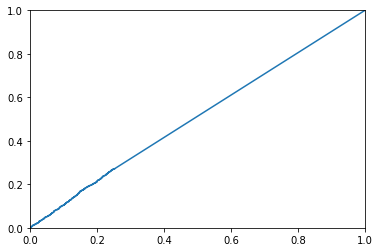

TRAIN: [    0     1     2 ... 61515 61516 61517] TEST: [20506 20507 20508 ... 41009 41010 41011]
Training...
Iteration 1, loss = 3.09226689
Iteration 2, loss = 0.70786191
Iteration 3, loss = 0.58158965
Iteration 4, loss = 0.52172281
Iteration 5, loss = 0.48261105
Iteration 6, loss = 0.45806761
Iteration 7, loss = 0.44400784
Iteration 8, loss = 0.43666284
Iteration 9, loss = 0.43302466
Iteration 10, loss = 0.43140157
Iteration 11, loss = 0.43077064
Iteration 12, loss = 0.43052196
Iteration 13, loss = 0.43044451
Iteration 14, loss = 0.43041735
Iteration 15, loss = 0.43042097
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Confusion matrix:
[[11053     0]
 [ 2114     0]]
Classification report:
             precision    recall  f1-score   support

        211       0.84      1.00      0.91     11053
        321       0.00      0.00      0.00      2114

avg / total       0.70      0.84      0.77     13167



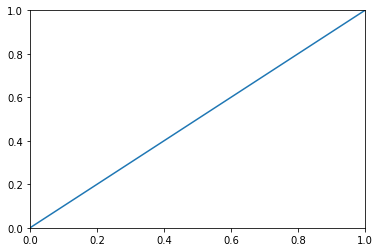

TRAIN: [    0     1     2 ... 41009 41010 41011] TEST: [41012 41013 41014 ... 61515 61516 61517]
Training...
Iteration 1, loss = 4.95942560
Iteration 2, loss = 0.99784751
Iteration 3, loss = 0.61081324
Iteration 4, loss = 0.47847340
Iteration 5, loss = 0.44502404
Iteration 6, loss = 0.43719037
Iteration 7, loss = 0.43516316
Iteration 8, loss = 0.43423879
Iteration 9, loss = 0.43370527
Iteration 10, loss = 0.43341979
Iteration 11, loss = 0.43324589
Iteration 12, loss = 0.43311472
Iteration 13, loss = 0.43304940
Iteration 14, loss = 0.43297098
Iteration 15, loss = 0.43292844
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Confusion matrix:
[[11102     2]
 [ 2081     0]]
Classification report:
             precision    recall  f1-score   support

        211       0.84      1.00      0.91     11104
        321       0.00      0.00      0.00      2081

avg / total       0.71      0.84      0.77     13185



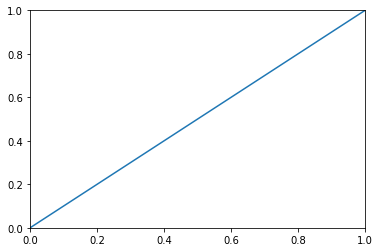

In [219]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)
kf.get_n_splits(X)
print (kf) 

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:",test_index)
    X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
    X_train = X_train.dropna()
    X_test  = X_test.dropna()
    
    y_train, y_test = y[train_index], y[test_index]
    y_train = y_train.dropna()
    y_test  = y_test.dropna()

    
    #train classifier on train data
    print("Training...")
    from sklearn.neural_network import MLPClassifier  
    mlp = MLPClassifier(hidden_layer_sizes=(len(attributes), int(len(attributes)/2), 10), max_iter=200, activation='relu', solver='adam', verbose=1)  
    mlp.fit(X_train, y_train.values.ravel()) 


    # make label predictions on test data
    predictions = mlp.predict(X_test) #this gives a 321 OR 211 label on the data 

    # evaluation
    from sklearn.metrics import classification_report, confusion_matrix
    print("Confusion matrix:")
    print(confusion_matrix(y_test,predictions))
    print("Classification report:")
    print(classification_report(y_test,predictions))
    
    #X_test comes with y_test
    # create a classification variable based on the prediction probability
    probabilities = mlp.predict_proba(X_test) # gives list of [prob_pion, prob_kaon]
    class_var = np.array( [ probabilities[i][0] for i in range(len(y_test)) ] ) # creates a list of prob_pion. only takes the first column of probabilities
    df_test = pd.DataFrame(data=X_test, columns=attributes)
    df_test["myMLP"] = class_var
    df_test["absid"] = y_test

    #changing labels from 321 and 211 to 0 and 1
    y_labels = np.array([y_test[:][i] for i in range(len(y_test)) ] ) #this is the original testing data 
    y_labels_b = (y_labels==211).astype(int) # this binarizes y_test. 211(pion) shows up as 1


    #plotting ROC curve. This gives the true positive rate on the y axis and false positive on the x
    from sklearn.metrics import roc_curve
    fpr,tpr,thresholds = roc_curve(y_labels_b,class_var) 
    plt.plot (fpr,tpr)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.show()


In [225]:
print(len(train_index))

41012


In [226]:
print(len(y_train))

49214


In [234]:
print(kf.split(X))

<generator object _BaseKFold.split at 0x7f14369113b8>


In [ ]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# Read tree as pandas dataframe using uproot
#tfile = uproot.open('../datafiles/output/davinci_MC_PID.root')
tfile = uproot.open('/home/Shared/lhcbdata/davinci_MC_PID.root')
tree = tfile["PiTree/DecayTree"]
df = tree.pandas.df()
#print(df.head())

# make new PID label abs
df['absid'] = df['pi_TRUEID'].abs()
#print(df['absid'].value_counts())



'/home/Shared/lhcbdata/ganga/20/subjobID/output/davinci_MC_PID.root' 

In [238]:
import pandas as pd # To be able to easily manipulate the data from the .root files.
import uproot # To be able to open .root files and turn their contents into dataframes.
import numpy as np # To be able to use linspace.

file_numbers = np.linspace(0, 99, 100) # Makes an array to access every folder in /home/Shared/lhc.data/ganga/20.
total_data_kaon_pion = pd.DataFrame() # Dataframe that will be filled up with the pions and kaons from all files.
for x in file_numbers: # Loops through all the files.
    number = '%.0f' % x # Makes the file number a string for the filename. Formatting done to ensure the string represents no decimals.
    file = uproot.open('/home/Shared/lhcbdata/ganga/20/'+number+'/output/davinci_MC_PID.root') # Opens one of the .root files.
    tree = file["PiTree/DecayTree"] # Accesses the tree of the root file.
    df = tree.pandas.df() # Turns the tree into a dataframe.
    
    tracking = df[['TrackP', 'TrackPt', 'TrackChi2PerDof', 'TrackLikelihood', 'TrackGhostProbability', 'TrackFitMatchChi2', 'TrackCloneDist', 'TrackFitVeloChi2', 'TrackFitVeloNDoF', 'TrackFitTChi2', 'TrackFitTNDoF']] # Desired tracking variables.
    RICH = df[['RichUsedAero', 'RichUsedR1Gas', 'RichUsedR2Gas', 'RichAboveMuThres', 'RichAboveKaThres', 'RichDLLe', 'RichDLLmu', 'RichDLLmu', 'RichDLLk', 'RichDLLp', 'RichDLLbt']] # Desired RICH variables.
    CALO = df[['EcalPIDe', 'EcalPIDmu', 'HcalPIDe', 'HcalPIDmu', 'PrsPIDe', 'InAccBrem', 'BremPIDe']] # Desired CALO variable.
    VELO = df[['VeloCharge']] # Desired VELO variable.
    ID = df[['pi_TRUEID']] # Particle IDs, known from simulation.
    data = pd.concat([tracking, RICH, CALO, VELO, ID], axis = 1) # Strings all variables and the particle IDs together into one dataframe.
    
    data_kaon_pion = data[(data.pi_TRUEID == -211) | (data.pi_TRUEID == 211) | (data.pi_TRUEID == -321) | (data.pi_TRUEID == 321)] # Filters the data to contain only pions, kaons and their antiparticles.
    # replace each value by what it should be
    data_kaon_pion = data_kaon_pion.replace(to_replace= 211, value= 1) # Pions get the ID 1.
    data_kaon_pion = data_kaon_pion.replace(to_replace= -211, value= 1) # Antipions get ID 1.
    data_kaon_pion = data_kaon_pion.replace(to_replace= 321, value= 0) # Kaons get ID 0.
    data_kaon_pion = data_kaon_pion.replace(to_replace= -321, value= 0) # Antikaons get ID 0.
    total_data_kaon_pion = pd.concat([total_data_kaon_pion, data_kaon_pion], axis = 0) # Links the data from one file to that of the files before it.
    print('File '+number+ ': done') # To see progress during the process.
total_data_kaon_pion_hdf5 = total_data_kaon_pion.to_hdf('particle_data_chungus_kaon0_pion1.h5', key = 'kaon_pion', format = 'table')

File 0: done
File 1: done
File 2: done
File 3: done
File 4: done
File 5: done
File 6: done
File 7: done
File 8: done
File 9: done
File 10: done
File 11: done
File 12: done
File 13: done
File 14: done
File 15: done
File 16: done
File 17: done
File 18: done
File 19: done
File 20: done
File 21: done
File 22: done
File 23: done
File 24: done
File 25: done
File 26: done
File 27: done
File 28: done
File 29: done
File 30: done
File 31: done
File 32: done
File 33: done
File 34: done
File 35: done
File 36: done
File 37: done
File 38: done
File 39: done
File 40: done
File 41: done
File 42: done
File 43: done
File 44: done
File 45: done
File 46: done
File 47: done
File 48: done
File 49: done
File 50: done
File 51: done
File 52: done
File 53: done
File 54: done
File 55: done
File 56: done
File 57: done
File 58: done
File 59: done
File 60: done
File 61: done
File 62: done
File 63: done
File 64: done
File 65: done
File 66: done
File 67: done
File 68: done
File 69: done
File 70: done
File 71: done
Fi

In [9]:

import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# Read tree as pandas dataframe using uproot
tfile = uproot.open('/home/Shared/lhcbdata/ganga/20/subjobID/output/davinci_MC_PID.root')
tree = tfile["PiTree/DecayTree"]
df = tree.pandas.df()
#print(df.head())

# make new PID label abs
df['absid'] = df['pi_TRUEID'].abs()
print(df['absid'].value_counts())

# make cuts on dataset
crit_global = (df['pi_TRACK_time_err'] > 0.1) & (df['pi_P'] > 1200)
crit_types  = (abs(df['pi_TRUEID']) == 211) | (abs(df['pi_TRUEID']) == 321) # only kaon or pion
dfsel = df[crit_global & crit_types]
#pion = 211, kaon = 321, proton = 2212


mc12 = ['pi_MC12TuneV4_ProbNNk', 'pi_MC12TuneV4_ProbNNp']
mc15 = ['pi_MC15TuneV1_ProbNNk', 'pi_MC15TuneV1_ProbNNp'] 
mc15_ = ['MC15TuneFLAT4dV1_ProbNNk', 'MC15TuneFLAT4dV1_ProbNNp', 'MC15TuneDNNV1_ProbNNk', 'MC15TuneDNNV1_ProbNNp', 'MC15TuneCatBoostV1_ProbNNk', 'MC15TuneCatBoostV1_ProbNNp']
tot = mc12 + mc15 +mc15_
P = dfsel.loc[ :, tot ]
print(P.head())

FileNotFoundError: [Errno 2] No such file or directory: '/home/Shared/lhcbdata/ganga/20/subjobID/output/davinci_MC_PID.root'